# Scientific Visualization

Visualize spatial accuracy patterns.

## Contents

1. **Setup** - Load data and train models
2. **TwoStageModel Prediction** - Density + Accuracy map
3. **Other Modes** - Observation, Interpolation, Average, SVM


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sys
from pathlib import Path

# Add geoequity to path
GEOEQUITY_ROOT = Path("..").resolve()
if str(GEOEQUITY_ROOT) not in sys.path:
    sys.path.insert(0, str(GEOEQUITY_ROOT))

from two_stage import TwoStageModel
from two_stage.model import find_bins_intervals
from two_stage.visualization import plot_predicted_accuracy_map
from visualization import plot_accuracy_map, plot_accuracy_comparison
from data import calculate_density, split_test_train
from data.feature import simple_feature_engineering

print("Ready!")


Ready!


## 1. Setup


In [2]:
# Load data
df = pd.read_pickle('data/df_example.pkl')
df['time'] = pd.to_datetime(df['time'])
df = df.sample(n=min(50000, len(df)), random_state=42).copy()
df['sufficiency'] = len(df)

# Prepare
TARGET_COL, MODEL_NAME = 'Ozone', 'linear'
df = calculate_density(df, radius=500)
_, _, train_idx, test_idx, df = split_test_train(df, split=0.2, flag='Site', seed=42, verbose=0)

# Train model
FEATURE_COLS = [c for c in ['TROPOMI_ozone', 'OMI_ozone', 'tco3', 'blh', 't2m'] if c in df.columns]
X, y, _ = simple_feature_engineering(df, FEATURE_COLS, TARGET_COL, standardize=True, verbose=False)
model = LinearRegression()
model.fit(X.loc[train_idx], y.loc[train_idx])
df[f'predicted_{MODEL_NAME}'] = model.predict(X)
df['observed'] = df[TARGET_COL]

stations = df.drop_duplicates(subset=['longitude', 'latitude'])
sufficiency = df['sufficiency'].iloc[0]
print(f"Data: {len(df):,} samples, {len(stations)} stations")


Calculating density (r=500km):   0%|          | 0/1301 [00:00<?, ?it/s]

Data: 50,000 samples, 1301 stations


## 2. TwoStageModel Prediction


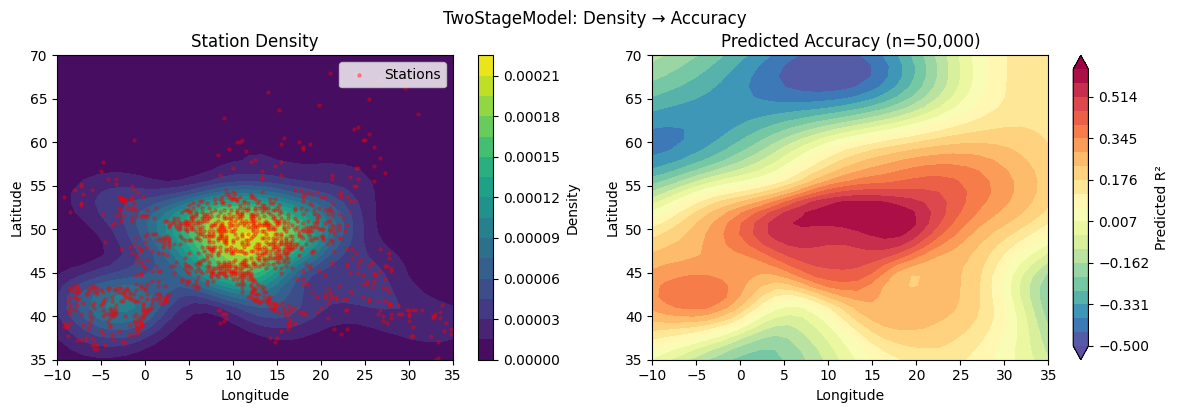

In [8]:
# Fit TwoStageModel
bins_intervals = find_bins_intervals(df, density_bins=7)
ts_model = TwoStageModel(spline=7, lam=0.5, resolution=[30, 30])
ts_model.fit(df.loc[test_idx], MODEL_NAME, bins_intervals, split_by='grid')

# Plot: Density + Predicted Accuracy
fig, axes = plot_predicted_accuracy_map(
    ts_model, 
    stations['longitude'].values, 
    stations['latitude'].values, 
    sufficiency,
    lon_range=(-10, 35), 
    lat_range=(35, 70), 
    grid_size=30,
   # accuracy_range=(0, 1)
)
plt.suptitle('TwoStageModel: Density → Accuracy', y=1.02)
plt.show()

**Note on Negative R² Values:**

R² can be negative when the model performs worse than predicting the mean. This happens when:
- Sparse regions have insufficient data for reliable predictions
- The model has poor generalization in certain areas

If negative R² values appear frequently, consider using alternative metrics:
- **MSE/RMSE**: Always positive, easier to interpret
- **MAE**: More robust to outliers
- **Correlation (r)**: Ranges from -1 to 1, captures linear relationship

## 3. Other Visualization Modes

| Mode | Description |
|------|-------------|
| `observation` | Per-station R² scatter |
| `interpolation` | IDW interpolation |
| `average_NxM` | Grid-averaged R² |
| `spatial_model` | SVM regression |
| `two_stage` | TwoStageModel prediction |


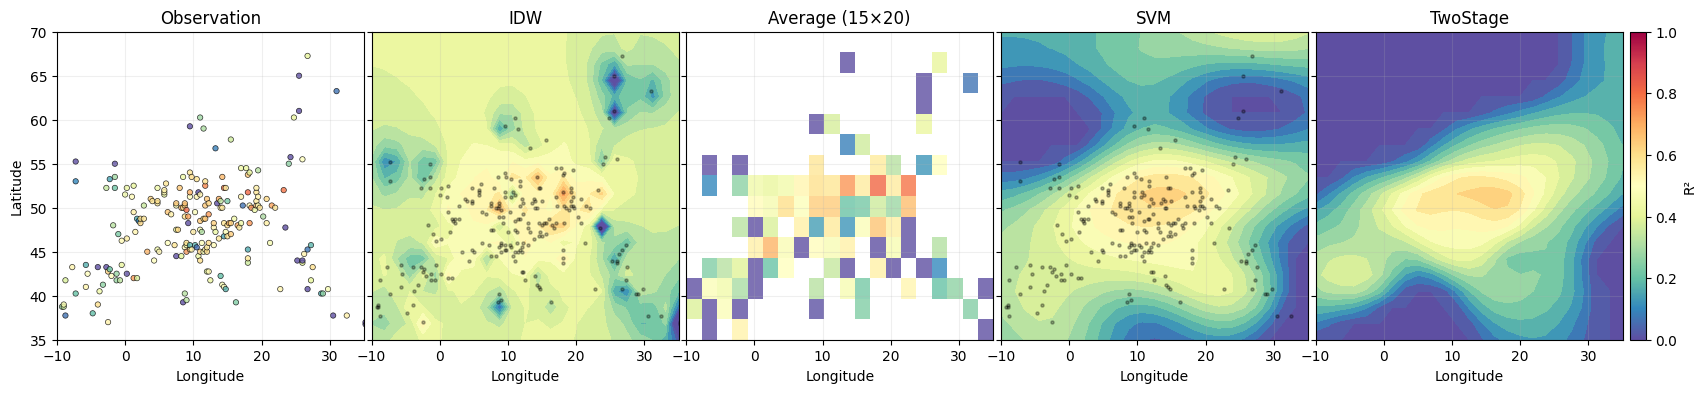

<Figure size 640x480 with 0 Axes>

In [7]:
# Compare all modes side by side (including two_stage)
fig, axes = plot_accuracy_comparison(
    df.loc[test_idx],
    model_name=MODEL_NAME,
    modes=['observation', 'interpolation', 'average_15x20', 'spatial_model', 'two_stage'],
    accuracy_range=(0, 1),
    lon_range=(-10, 35),
    lat_range=(35, 70),
    # Required for 'two_stage' mode:
    ts_model=ts_model,
    station_lons=stations['longitude'].values,
    station_lats=stations['latitude'].values
)
plt.suptitle(f'{MODEL_NAME} - Visualization Modes', y=1.02)
plt.show()


## Summary

| Function | Description |
|----------|-------------|
| `plot_predicted_accuracy_map` | TwoStageModel prediction (density + accuracy) |
| `plot_accuracy_comparison` | Compare multiple modes side by side |
| `plot_accuracy_map` | Single mode visualization |
